In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def f(x):
    return 3*x**2-4*x+5

In [8]:
print(f(0))
print(f(-1))
print(f(1))

5
12
4


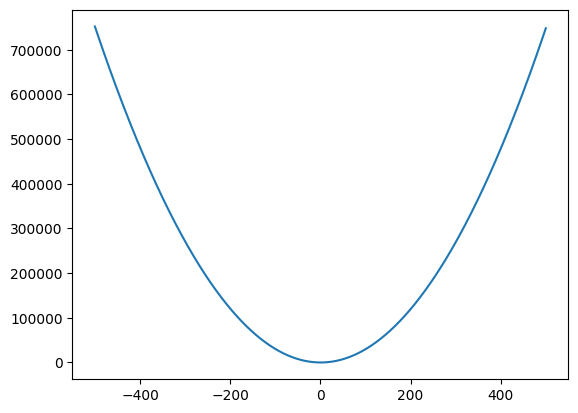

In [9]:
xs=np.arange(-500,500.1,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [10]:
a=2
b=-3
c=10
d=a*b+c
print(d)

4


In [11]:
h=0.001
a=2
b=-3
c=10

d1=a*b+c
c+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4
d2 4.0009999999999994
slope 0.9999999999994458


In [42]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data+other.data,(self,other),'+')
        return out

    def __mul__(self,other):
        out = Value(self.data*other.data,(self,other),'*')
        return out

    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        return out
        

a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0, label='f')
L=d*f;L.label='l'
L

Value(data=-8.0)

In [38]:
from graphviz import Digraph

def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
                
def draw_dot(root, format='svg', rankdir='LR'):

    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s  | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



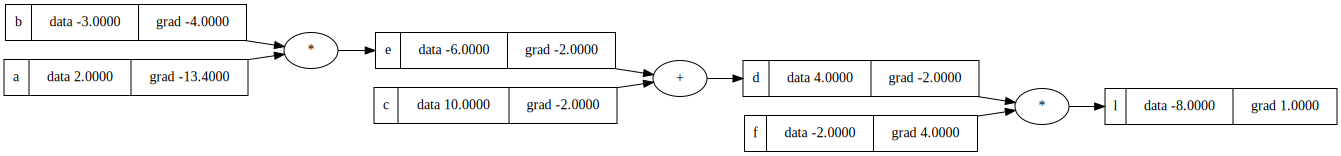

In [39]:
L.grad=1
f.grad=d.data
d.grad=f.data
c.grad=d.grad
e.grad=d.grad
a.grad=e.grad*b.data
b.grad=a.data*e.grad
draw_dot(L)

In [29]:
def test():

    h=0.001
    
    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0, label='f')
    L=d*f;L.label='l'
    L1=L.data

    a=Value(2.0+h,label='a')
    b=Value(-3.0,label='b')
    c=Value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0, label='f')
    L=d*f;L.label='l'
    L2=L.data
    print((L2-L1)/h)

test()

6.000000000000227


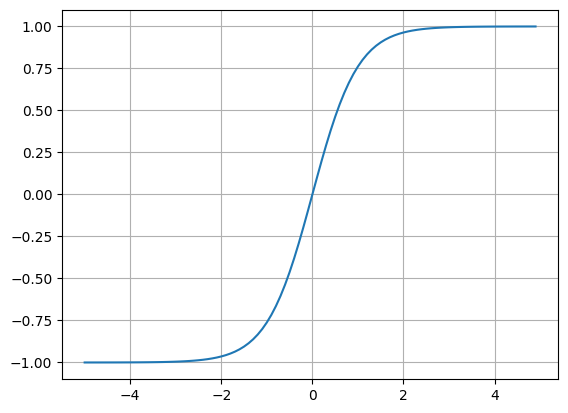

In [34]:
plt.plot(np.arange(-5,5,0.1),np.tanh(np.arange(-5,5,0.1)));plt.grid();

In [52]:
#input c1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights w1,w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias of the neuron
#the data is strange to make reading value of further calculation easier
b=Value(6.8813735870195432,label='b')

#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'


In [64]:
o.grad=1.0
#o=tanh(n)
#do/dn= 1 - o**2
n.grad=1-o.data**2
b.grad=0.5
x1w1x2w2.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

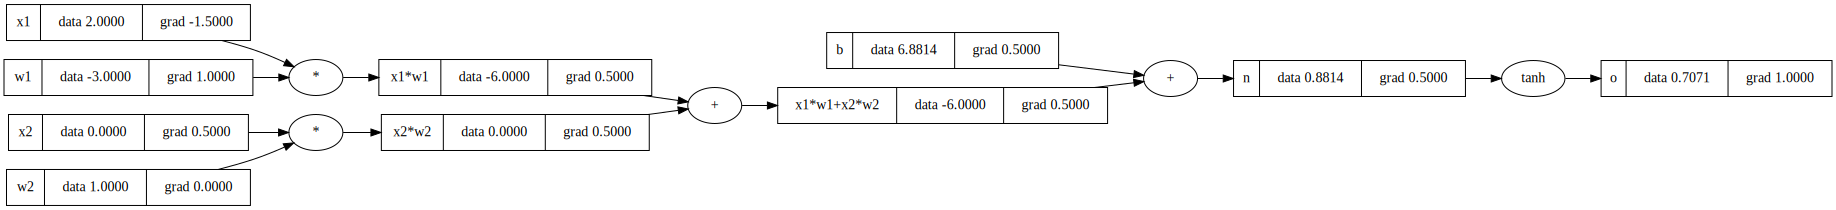

In [65]:
draw_dot(o)